# Q6

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data0 = np.loadtxt("data0.txt")
X0 = data0[:,:2]
y0 = data0[:,-1]
print(X0.shape, y0.shape)

(48, 2) (48,)


In [3]:
def converged(w, b, X, y):
  predictions = np.argmax((X @ w) + b.reshape((1, -1)), axis=1)
  return np.allclose(predictions, y)
def perceptron(X, y):
  num_classes = len(np.unique(y))
  n = X.shape[0]
  w = np.zeros((X.shape[1], num_classes))
  b = np.zeros(num_classes)

  perm = np.random.choice(range(n), n, replace=False)
  X_perm = X[perm]
  y_perm = y[perm]
  num_iterations = 0
  max_iterations = 999
  while not converged(w, b, X, y) and num_iterations < max_iterations:
    for i in range(n):
      Xi = X_perm[i]
      yi = int(y_perm[i])
      y_pred = int(np.argmax(Xi.reshape((1, -1)) @ w + b))
      if yi != y_pred:
        w[:,yi] += Xi
        b[yi] += 1
        w[:,y_pred] -= Xi
        b[y_pred] -= 1
    num_iterations += 1
  return w, b
def plot0(X, y, w, b):
  min_x1, max_x1 = np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5
  min_x2, max_x2 = np.min(X[:,1]) - 0.5, np.max(X[:,1]) + 0.5
  delta = 0.1

  plt.xlim(min_x1, max_x1)
  plt.ylim(min_x2, max_x2)

  xx, yy = np.meshgrid(np.arange(min_x1, max_x1 + delta, delta), np.arange(min_x2, max_x2 + delta, delta))
  pairs = np.c_[xx.flatten(), yy.flatten()]
  zz = np.zeros(len(pairs))
  for i, pair in enumerate(pairs):
    pair2 = pair.reshape((1, -1))
    zz[i] = np.argmax((pair2 @ w ).flatten() + b)
  zz = zz.reshape(xx.shape)
  styles = ["^r", "og", "pb", "*m"]
  for i in range(4):
    Xi, yi = X[y==i], y[y==i]
    plt.plot(Xi[:,0], Xi[:,1], styles[i])
  plt.pcolormesh(xx, yy, zz, cmap="rainbow", vmin=0, vmax=4)
  plt.show()

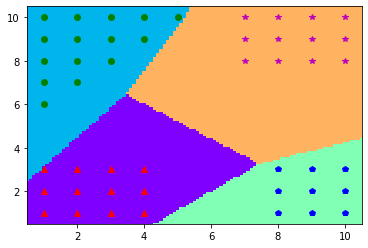

In [4]:
np.random.seed(123)

w, b = perceptron(X0, y0)
plot0(X0, y0, w, b)

# Q7

In [5]:
data1 = np.loadtxt("data1.txt")
data2 = np.loadtxt("data2.txt")

X1, y1 = data1[:,:-1], data1[:,-1]
X2, y2 = data2[:,:-1], data2[:,-1]
print(X1.shape, X2.shape, y1.shape, y2.shape)

(76, 2) (60, 2) (76,) (60,)


In [6]:
def kernel_classify(b, X, x, y, alpha):
  terms = alpha.flatten() * y.flatten()
  dots = np.square(1 + X @ x.reshape((-1, 1))).flatten()
  w_dot_phi = np.dot(terms, dots)
  decision = w_dot_phi + b
  return np.sign(decision)

def kernel_converge(b, X, y, alpha):
  dot_matrix = np.square(1 + X @ X.T)
  column_terms = (alpha * y).reshape((-1, 1))

  logit_matrix = dot_matrix * column_terms
  predictions = np.sum(logit_matrix, axis=0) + b
  return np.allclose(np.sign(predictions), y)

def kernel_perceptron(X, y):
  n, d = X.shape
  alpha = np.zeros(n)
  b = 0
  
  for i in range(8000):
    perm = np.random.choice(n, n, replace=False)
    for j in perm:
      xj = X[j]
      yj = y[j]
      if kernel_classify(b, X, xj, y, alpha) != yj:
        alpha[j] += 1
        b += yj
    if kernel_converge(b, X, y, alpha):
      return alpha, b, X, y
  raise Exception("Did not converge")
  

def gen_classify(alpha, b, X, y):
  def clas(x):
    phis = ((1 + X @ x.reshape((-1, 1))) ** 2).flatten()
    decision = np.sum(alpha * y * phis) + b
    return np.sign(decision)
  return clas

def plot1(X, y, classify, title=""):
  min_x1, max_x1 = np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5
  min_x2, max_x2 = np.min(X[:,1]) - 0.5, np.max(X[:,1]) + 0.5
  delta = 0.1

  plt.xlim(min_x1, max_x1)
  plt.ylim(min_x2, max_x2)

  xx, yy = np.meshgrid(np.arange(min_x1, max_x1 + delta, delta), np.arange(min_x2, max_x2 + delta, delta))
  pairs = np.c_[xx.flatten(), yy.flatten()]
  zz = np.zeros(len(pairs))
  for i, pair in enumerate(pairs):
    pair2 = pair.reshape((1, -1))
    zz[i] = classify(pair)
  zz = zz.reshape(xx.shape)
  styles = ["^r", "og"]
  for idx, label in enumerate([-1, 1]):
    Xi, yi = X[y==label], y[y==label]
    plt.plot(Xi[:,0], Xi[:,1], styles[idx])
  plt.pcolormesh(xx, yy, zz, cmap=plt.cm.PRGn, vmin=-2, vmax=2)
  if title:
    plt.title(title)
  plt.show()

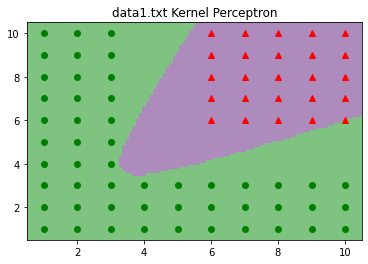

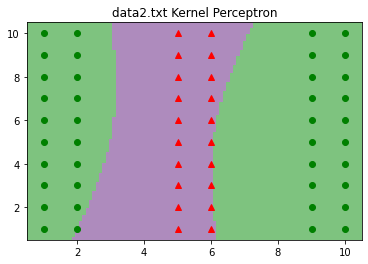

In [7]:
np.random.seed(123)
alpha_1, b_1, X_1, y_1 = kernel_perceptron(X1, y1)
clas_1 = gen_classify(alpha_1, b_1, X_1, y_1)
plot1(X_1, y_1, clas_1, title = "data1.txt Kernel Perceptron")

np.random.seed(999)
alpha_2, b_2, X_2, y_2 = kernel_perceptron(X2, y2)
clas_2 = gen_classify(alpha_2, b_2, X_2, y_2)
plot1(X_2, y_2, clas_2, title = "data2.txt Kernel Perceptron")

In [8]:
def rbf_classify(b, X, x, y, alpha, s):
  terms = alpha.flatten() * y.flatten()
  distances = np.exp(-np.sum(np.square(X - x.reshape((1, -1))), axis = 1) / (s ** 2))
  decision = np.sum(distances * terms) + b
  return np.sign(decision)

def rbf_converge(b, X, y, alpha, s):
  n, d = X.shape
  terms = alpha.flatten() * y.flatten()
  for i in range(n):
    xi = X[i]
    yi = y[i]
    distances = np.exp(-np.sum(np.square(X - xi.reshape((1, -1))), axis = 1) / (s ** 2))
    decision = np.sum(distances * terms) + b
    if not np.sign(decision) == yi:
      return False
  return True

def rbf_perceptron(X, y, s):
  n, d = X.shape
  alpha = np.zeros(n)
  b = 0
  
  for i in range(8000):
    perm = np.random.choice(n, n, replace=False)
    for j in perm:
      xj = X[j]
      yj = y[j]
      if rbf_classify(b, X, xj, y, alpha, s) != yj:
        alpha[j] += 1
        b += yj
    if rbf_converge(b, X, y, alpha, s):
      return alpha, b, X, y
  raise Exception("Did not converge")
  
def rbf_gen_classify(alpha, b, X, y, s):
  def clas(x):
    terms = alpha.flatten() * y.flatten()
    distances = np.exp(-np.sum(np.square(X - x.reshape((1, -1))), axis = 1) / (s ** 2))
    decision = np.sum(distances * terms) + b
    return np.sign(decision)
  return clas

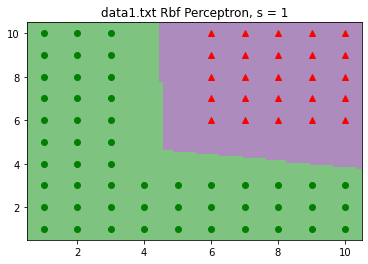

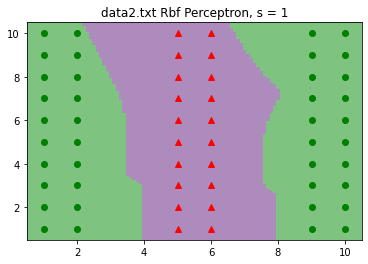

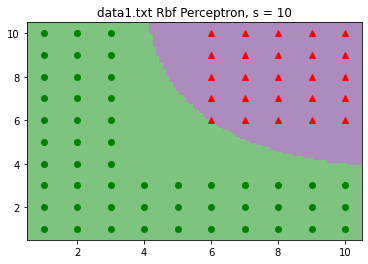

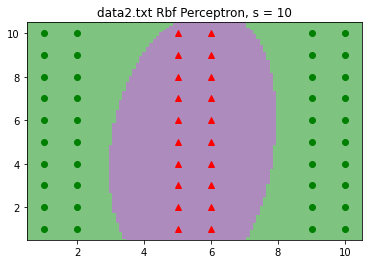

In [9]:
s = 1

np.random.seed(123)
alpha_1, b_1, X_1, y_1 = rbf_perceptron(X1, y1, s)
clas_1 = rbf_gen_classify(alpha_1, b_1, X_1, y_1, s)
plot1(X_1, y_1, clas_1, title = f"data1.txt Rbf Perceptron, s = {s}")

np.random.seed(999)
alpha_2, b_2, X_2, y_2 = rbf_perceptron(X2, y2, s)
clas_2 = rbf_gen_classify(alpha_2, b_2, X_2, y_2, s)
plot1(X_2, y_2, clas_2, title = f"data2.txt Rbf Perceptron, s = {s}")

s = 10

np.random.seed(123)
alpha_1, b_1, X_1, y_1 = rbf_perceptron(X1, y1, s)
clas_1 = rbf_gen_classify(alpha_1, b_1, X_1, y_1, s)
plot1(X_1, y_1, clas_1, title = f"data1.txt Rbf Perceptron, s = {s}")

np.random.seed(999)
alpha_2, b_2, X_2, y_2 = rbf_perceptron(X2, y2, s)
clas_2 = rbf_gen_classify(alpha_2, b_2, X_2, y_2, s)
plot1(X_2, y_2, clas_2, title = f"data2.txt Rbf Perceptron, s = {s}")

# Q8

In [10]:
import sklearn.datasets as ds

data = ds.fetch_openml("mnist_784")

c:\Users\James\anaconda3\envs\mlenv\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [11]:
X = data['data'].to_numpy()
y = np.array([int(q) for q in data['target']])

print(X.shape, y.shape)
X_tr, X_te = X[:60000,:], X[60000:,:]
y_tr, y_te = y[:60000], y[60000:]

print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

(70000, 784) (70000,)
(60000, 784) (10000, 784) (60000,) (10000,)


In [12]:
from sklearn.svm import LinearSVC

def experiment(svm: LinearSVC, X_tr, X_te, y_tr, y_te):
  reg = svm.fit(X_tr, y_tr)
  pred_tr = reg.predict(X_tr)
  pred_te = reg.predict(X_te)

  err_tr = np.mean(np.not_equal(y_tr.flatten(), pred_tr))
  err_te = np.mean(np.not_equal(y_te.flatten(), pred_te))

  return err_tr, err_te, reg

for C in [0.01, 0.1, 1.0, 10, 100]:
  svm = LinearSVC(loss="hinge", C=C, max_iter=100)
  err_tr, err_te, reg = experiment(svm, X_tr, X_te, y_tr, y_te)
  print(f"C={C}")
  print(f"\t{err_tr=}, {err_te=}")

c:\Users\James\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=0.01
	err_tr=0.15438333333333334, err_te=0.1579


c:\Users\James\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=0.1
	err_tr=0.13591666666666666, err_te=0.1429


c:\Users\James\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=1.0
	err_tr=0.12038333333333333, err_te=0.1219


c:\Users\James\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=10
	err_tr=0.13311666666666666, err_te=0.1326
C=100
	err_tr=0.15, err_te=0.1626


c:\Users\James\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [14]:
from sklearn.svm import SVC

svm = SVC(kernel="poly", degree = 2, C=1.0, max_iter=500)
err_tr, err_te, reg = experiment(svm, X_tr, X_te, y_tr, y_te)
print(f"C={1}")
print(f"\t{err_tr=}, {err_te=}")
print(f"\tnum_sup_vec = {len(reg.support_)=}")

c:\Users\James\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=1
	err_tr=0.013966666666666667, err_te=0.0244
	num_sup_vec = len(reg.support_)=9158


In [15]:
import matplotlib.pyplot as plt

(1000, 1000) (1000, 1000)
(1000, 1000)


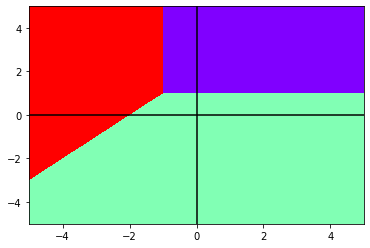

In [22]:
xx, yy = np.meshgrid(np.arange(-5, 5, 0.01), np.arange(-5, 5, 0.01))
c1 = xx + yy
c2 = xx + 1
c3 = yy - 1
z = np.argmax(np.stack((c1, c2, c3)), axis=0)
print(xx.shape, yy.shape)
print(z.shape)
plt.pcolormesh(xx, yy, z, cmap="rainbow", vmin=0, vmax=2)
plt.axhline(0, color='black')
plt.axvline(0, color='black')